In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump, load
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

## Setup Parameters

In [2]:
churn_filepath = Path('data')/'Churn_Modelling.csv'
cat_cols = []
num_cols =  [
        'CreditScore',
        'Age',
        'Tenure',
        'Balance',
        'NumOfProducts',
        'HasCrCard',
        'IsActiveMember',
        'EstimatedSalary'
        ]
targ_col = 'Exited'
test_size = 0.25
random_state = 42
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)
model_fname = 'model.joblib'

In [3]:
# papermill parameter
model_type = 'random-forest'
n_estimators = 50
max_depth = 5

In [4]:
train_params = {'n_estimators': n_estimators, 
                'max_depth': max_depth}

## Read Data

In [5]:
df = pd.read_csv(churn_filepath)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Exploration

In [6]:
df.shape

(10000, 14)

In [7]:
# Are there missing values?
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

## Data Preprocessing and Splitting

In [9]:
X, y = df[cat_cols + num_cols], df[targ_col]

In [10]:
y.mean()

0.2037

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_state)

## Train Model

In [12]:
if model_type == 'random-forest':
    clf = RandomForestClassifier(random_state=random_state, **train_params)
elif model_type == 'lightgbm':
    clf = LGBMClassifier(random_state=random_state, **train_params)
else:
    raise Exception('Unsupported model_type')
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [13]:
dump(clf, models_dir/model_fname)

['models/model.joblib']

In [14]:
clf = load(models_dir/model_fname)

## Model Evaluation

/Users/akim/Desktop/gh/iter/demo-bank-customer-churn/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


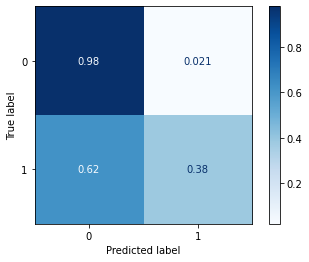

In [15]:
plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.savefig(Path('eval_plots')/'cm.png')

In [16]:
y_prob = clf.predict_proba(X_test)
y_pred = y_prob[:, 1] >= 0.5

In [17]:
from dvclive import Live
live = Live("eval_plots")
live.log_sklearn_plot("roc", y_test, y_prob[:, 1])

INFO:dvclive:Report path (if generated): /Users/akim/Desktop/gh/iter/demo-bank-customer-churn/eval_plots/report.html


In [18]:
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])
metrics = {
        'f1': f1,
        'roc_auc': roc_auc
    }
metrics

{'f1': 0.5192307692307692, 'roc_auc': 0.8356825928109848}

In [19]:
json.dump(
    obj=metrics,
    fp=open('metrics.json', 'w'),
    indent=4, 
    sort_keys=True
)